In [93]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


Let's start by generating fake data

In [18]:
T = 1 # seconds
dt = 0.1 # sampling rate
T = int(T* 1000) # convert time in seconds into total samples
N_nrn = 120

events_binary = np.zeros((T,N_nrn))

Make a kernel so that the activity of one neuron affects neurons around it according to the shape of some kernel

In [19]:
nrn_kern_x = np.arange(0-int(N_nrn/2),int(N_nrn/2))
nrn_kern = -np.sin(0.02*nrn_kern_x -1.2) + 0.5*np.sin(0.15*nrn_kern_x-1.2)
nrn_kern /= np.max(nrn_kern)

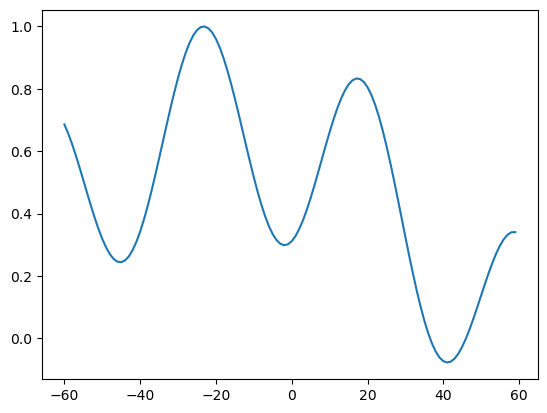

In [20]:
plt.figure()
plt.plot(nrn_kern_x, nrn_kern)
plt.show()

Okay now each neuron will recieve one of the 2 neurons

In [21]:
T

1000

In [22]:
inp1 = 10/2 * (1 +np.sin(0.02*np.arange(0,T)))+ np.random.randint(10,size=T)/1
inp2 = 10/2 * (1 +np.cos(0.01*np.arange(0,T)))+ np.random.randint(10,size=T)/1

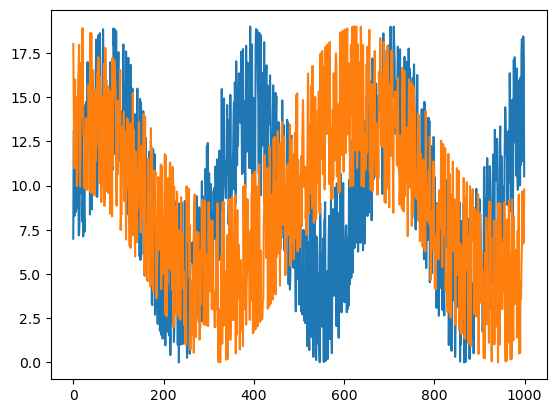

In [23]:
plt.figure()
plt.plot(inp1)
plt.plot(inp2)
plt.show()

neuron model - shamelessly stolen from https://github.com/Devrim-Celik/interactive_neuron_model_simulator/blob/master/Models/Izhikevich_Interactive.py to save time

In [24]:
def run(I, a = 0.02, b = 0.2, c = -55, d = 4):
    T = len(I)
    dt=1
    ######### Constants
    spike_value = 35                            # Maximal Spike Value

    ######### Experimental Setup
    # VOLTAGE
    V               =   np.zeros(int(T))     # array for saving voltage history
    V[0]            =   -70                     # set initial to resting potential
    # RECOVERY
    u               =   np.zeros(int(T/dt))     # array for saving Recovery history
    u[0]            =   -14
    
    spikes = []

    for t in range(1, T):
        # if we still didnt reach spike potential
        if V[t-1] < spike_value:
            # ODE for membrane potential
            dV      = (0.04 * V[t-1] + 5) * V[t-1] + 140 - u[t-1]
            V[t]    = V[t-1] + (dV + I[t-1]) * dt
            # ODE for recovery variable
            du      = a * (b * V[t-1] - u[t-1])
            u[t]    = u[t-1] + dt * du
        # spike reached!
        else:
            V[t-1] = spike_value    # set to spike value
            V[t] = c                # reset membrane voltage
            u[t] = u[t-1] + d       # reset recovery
            spikes.append(t-1)
    
    return V, spikes

In [25]:
len(np.arange(0,T,0.1))

10000

now let's make a raster plot pleease

In [26]:
'''
neuron types 
1:RS
2:IB
3:FS
4:LTS
'''


params = np.array((
[0.02, 0.02, 0.1, 0.02],
    [0.2,0.2,0.2,0.25],
    [-65, -55, -65, -65],
    [8, 4, 2, 2]
) )
# types is a 4x4 matrix -> types[0] = a parameters for each neuron type

In [27]:
events_binary = np.zeros((T,N_nrn))
all_spikes = np.array([])
idc = np.array([])
types = np.array([])
for n in range(N_nrn):
    inp1 = 10/2 * (1 +np.sin(0.05*np.arange(0,T)))+ 2*np.random.randint(10,size=T)
    inp2 = 10/2 * (1 +np.cos(0.01*np.arange(0,T)))+ 2*np.random.randint(10,size=T)
    if n<N_nrn/2:
        _, spikes = run(inp1,a=params[0][n%4],b=params[1][n%4],c=params[2][n%4],d=params[3][n%4])
    else:
        _, spikes = run(inp2,a=params[0][n%4],b=params[1][n%4],c=params[2][n%4],d=params[3][n%4])
    all_spikes = np.hstack((all_spikes,spikes))
    idc = np.hstack((idc, n*np.ones(len(spikes))))
    types = np.hstack((idc, n%4 * np.ones(len(spikes))))
    events_binary[spikes,n] = 1

In [28]:
len(all_spikes[idc%4==0]), len(idc[idc%4==0])

(986, 986)

In [29]:
x = np.array([1,2,3,4,5,5,9,5,4,3,2])
np.where(x==np.max(x))[0], np.max(x)

(array([6], dtype=int64), 9)

In [30]:
firing_rates = []
median_isis = []
mean_isis = []
var_isis = []
isis = []
for n in range(N_nrn):
    firing_rates.append(len(all_spikes[idc==n]))
    median_isis.append(np.median(np.diff(all_spikes[idc==n])))
    mean_isis.append(np.mean(np.diff(all_spikes[idc==n])))
    var_isis.append(np.var(np.diff(all_spikes[idc==n])))
    isis.append(np.diff(all_spikes[idc==n]))
    
    

I kinda want to make a SDF that is smoother...

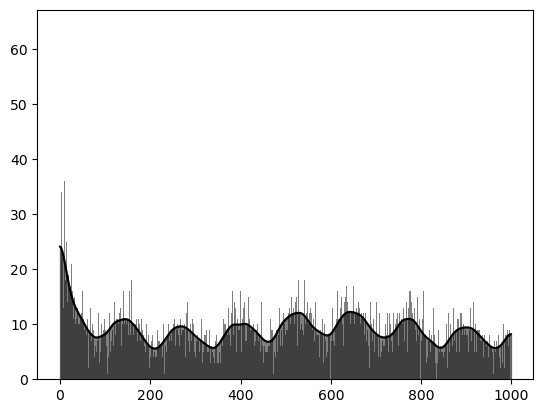

In [38]:
plt.figure()
x = plt.hist(all_spikes,bins=1000,alpha=0.5,color='black')
plt.fill_between(np.arange(0,len(x[0])), gaussian_filter1d(x[0],10),color='black',alpha=0.5)
plt.plot(gaussian_filter1d(x[0],10),color='black')
plt.show()

In [42]:
inp1.shape


(1000,)

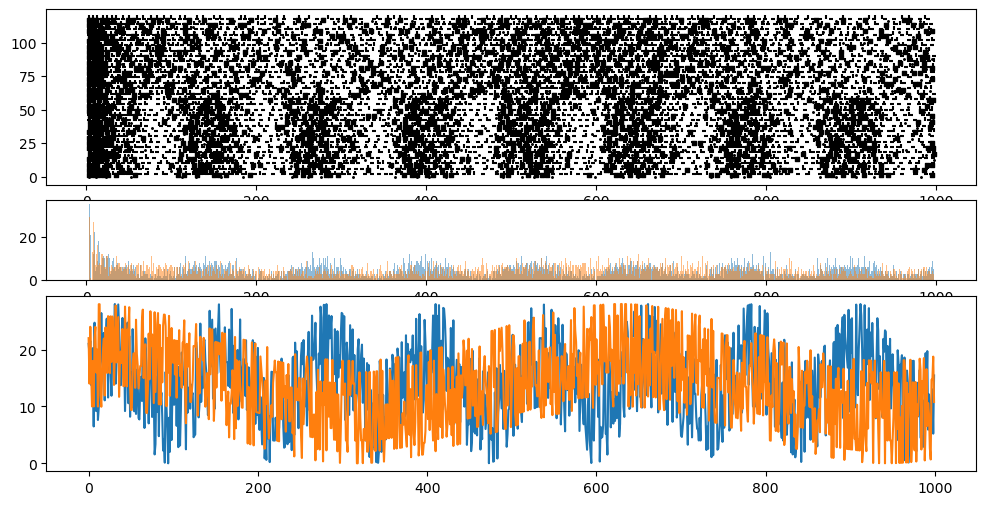

In [44]:
%matplotlib inline
fig,ax = plt.subplot_mosaic('A;A;B;C;C',figsize=(12,6))

ax['A'].scatter(all_spikes[idc%4==0],idc[idc%4==0],marker='.',color='black',s=5)
ax['A'].scatter(all_spikes[idc%4==1],idc[idc%4==1],marker=',',color='black',s=5)
ax['A'].scatter(all_spikes[idc%4==2],idc[idc%4==2],marker='_',color='black',s=5)
ax['A'].scatter(all_spikes[idc%4==3],idc[idc%4==3],marker='|',color='black',s=5)


# for k in range(2):
#     ax['B'].plot(np.arange(0,T,dt),run(inp1, a=params[0][k],b=params[1][k],c=params[2][k],d=params[3][k])[0])

ax['B'].hist(all_spikes[idc<60],bins=1000,alpha=0.5)
ax['B'].hist(all_spikes[idc>=60],bins=1000,alpha=0.5)
# ax['B'].set_xlim([0, np.max(np.diff(all_spikes))])
# ax['B'].set_ylim([0,  np.where(np.diff(all_spikes)==np.max(np.diff(all_spikes)))[0]])


ax['C'].plot(np.arange(0,T),inp1)
ax['C'].plot(np.arange(0,T),inp2)
plt.show()

Make some labels for later

In [45]:
labels = np.zeros(120)
labels[np.arange(0,len(labels))%4==1] = 1
labels[np.arange(0,len(labels))%4==2] = 2
labels[np.arange(0,len(labels))%4==3] = 3
labels[np.arange(0,len(labels))>=60] +=4
labels

array([0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3., 0.,
       1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3., 0., 1.,
       2., 3., 0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2.,
       3., 0., 1., 2., 3., 0., 1., 2., 3., 4., 5., 6., 7., 4., 5., 6., 7.,
       4., 5., 6., 7., 4., 5., 6., 7., 4., 5., 6., 7., 4., 5., 6., 7., 4.,
       5., 6., 7., 4., 5., 6., 7., 4., 5., 6., 7., 4., 5., 6., 7., 4., 5.,
       6., 7., 4., 5., 6., 7., 4., 5., 6., 7., 4., 5., 6., 7., 4., 5., 6.,
       7.])

Feature selection!!!
so the first feature could just be the firing rate i suppose?

features: firing rate, inter-spike-interval, frequency spectra?

In [46]:
norm = lambda a : a/ np.max(a)

In [47]:
norm([1,5,3,4,2,3,4,5,])

array([0.2, 1. , 0.6, 0.8, 0.4, 0.6, 0.8, 1. ])

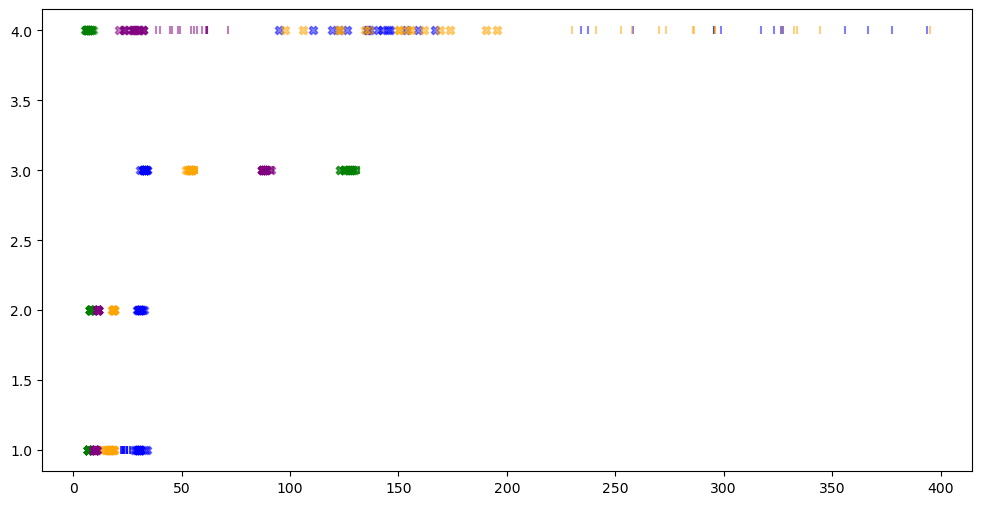

In [48]:

fig,ax = plt.subplot_mosaic('A',figsize=(12,6))

ax['A'].scatter(median_isis[:60:4], np.ones(len(median_isis[:60:4])) ,alpha=0.5, color='blue', marker='|')
ax['A'].scatter(median_isis[1:60:4], np.ones(len(median_isis[1:60:4])) ,alpha=0.5, color='orange', marker='|')
ax['A'].scatter(median_isis[2:60:4], np.ones(len(median_isis[2:60:4])) ,alpha=0.5, color='green', marker='|')
ax['A'].scatter(median_isis[3:60:4], np.ones(len(median_isis[3:60:4])) ,alpha=0.5, color='purple', marker='|')

ax['A'].scatter(mean_isis[:60:4], 2*np.ones(len(mean_isis[:60:4])) ,alpha=0.5, color='blue', marker='|')
ax['A'].scatter(mean_isis[1:60:4], 2*np.ones(len(mean_isis[1:60:4])) ,alpha=0.5, color='orange', marker='|')
ax['A'].scatter(mean_isis[2:60:4], 2*np.ones(len(mean_isis[2:60:4])) ,alpha=0.5, color='green', marker='|')
ax['A'].scatter(mean_isis[3:60:4], 2*np.ones(len(mean_isis[3:60:4])) ,alpha=0.5, color='purple', marker='|')

ax['A'].scatter(firing_rates[:60:4], 3*np.ones(len(firing_rates[:60:4])) ,alpha=0.5, color='blue', marker='|')
ax['A'].scatter(firing_rates[1:60:4], 3*np.ones(len(firing_rates[1:60:4])) ,alpha=0.5, color='orange', marker='|')
ax['A'].scatter(firing_rates[2:60:4], 3*np.ones(len(firing_rates[2:60:4])) ,alpha=0.5, color='green', marker='|')
ax['A'].scatter(firing_rates[3:60:4], 3*np.ones(len(firing_rates[3:60:4])) ,alpha=0.5, color='purple', marker='|')

ax['A'].scatter(var_isis[:60:4], 4*np.ones(len(var_isis[:60:4])) ,alpha=0.5, color='blue', marker='|')
ax['A'].scatter(var_isis[1:60:4], 4*np.ones(len(var_isis[1:60:4])) ,alpha=0.5, color='orange', marker='|')
ax['A'].scatter(var_isis[2:60:4], 4*np.ones(len(var_isis[2:60:4])) ,alpha=0.5, color='green', marker='|')
ax['A'].scatter(var_isis[3:60:4], 4*np.ones(len(var_isis[3:60:4])) ,alpha=0.5, color='purple', marker='|')

ax['A'].scatter(median_isis[60:120:4], np.ones(len(median_isis[60:120:4])),alpha=0.5, color='blue', marker='X')
ax['A'].scatter(median_isis[60+1:120:4], np.ones(len(median_isis[60+1:120:4])),alpha=0.5, color='orange', marker='X')
ax['A'].scatter(median_isis[60+2:120:4], np.ones(len(median_isis[60+2:120:4])), alpha=0.5,color='green', marker='X')
ax['A'].scatter(median_isis[60+3:120:4], np.ones(len(median_isis[60+3:120:4])),alpha=0.5, color='purple', marker='X')

ax['A'].scatter(mean_isis[60:120:4], 2*np.ones(len(mean_isis[60:120:4])), alpha=0.5,color='blue', marker='X')
ax['A'].scatter(mean_isis[60+1:120:4], 2*np.ones(len(mean_isis[60+1:120:4])), alpha=0.5,color='orange', marker='X')
ax['A'].scatter(mean_isis[60+2:120:4], 2*np.ones(len(mean_isis[60+2:120:4])), alpha=0.5,color='green', marker='X')
ax['A'].scatter(mean_isis[60+3:120:4], 2*np.ones(len(mean_isis[60+3:120:4])), alpha=0.5,color='purple', marker='X')

ax['A'].scatter(firing_rates[60:120:4], 3*np.ones(len(firing_rates[60:120:4])), alpha=0.5,color='blue', marker='X')
ax['A'].scatter(firing_rates[60+1:120:4], 3*np.ones(len(firing_rates[60+1:120:4])),alpha=0.5, color='orange', marker='X')
ax['A'].scatter(firing_rates[60+2:120:4], 3*np.ones(len(firing_rates[60+2:120:4])),alpha=0.5, color='green', marker='X')
ax['A'].scatter(firing_rates[60+3:120:4], 3*np.ones(len(firing_rates[60+3:120:4])),alpha=0.5, color='purple', marker='X')

ax['A'].scatter(var_isis[60:120:4], 4*np.ones(len(var_isis[60:120:4])),alpha=0.5, color='blue', marker='X')
ax['A'].scatter(var_isis[60+1:120:4], 4*np.ones(len(var_isis[60+1:120:4])),alpha=0.5, color='orange', marker='X')
ax['A'].scatter(var_isis[60+2:120:4], 4*np.ones(len(var_isis[60+2:120:4])),alpha=0.5, color='green', marker='X')
ax['A'].scatter(var_isis[60+3:120:4], 4*np.ones(len(var_isis[60+3:120:4])),alpha=0.5,color='purple', marker='X')


plt.show()

# Can I form clusters without taking a PCA?

[]

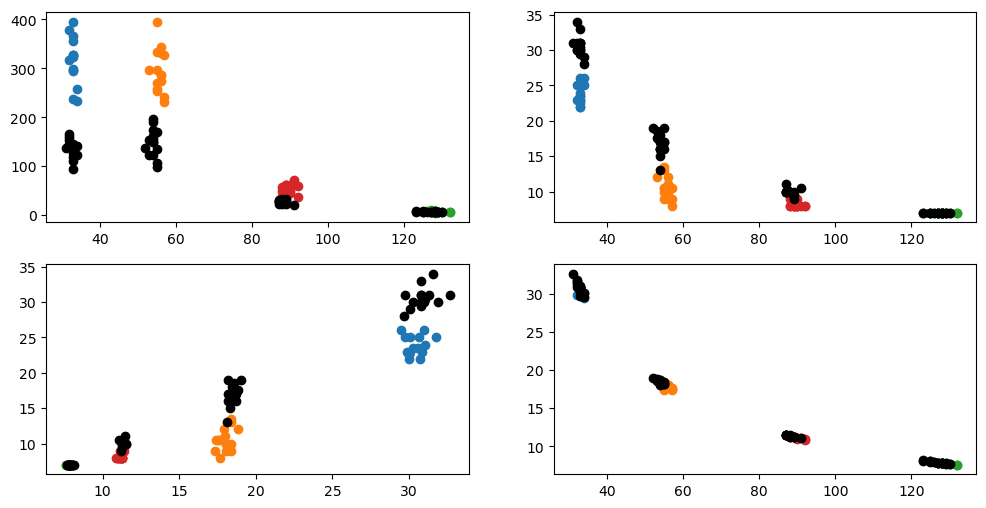

In [49]:
fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))

ax['A'].scatter(firing_rates[:60:4], var_isis[:60:4])
ax['A'].scatter(firing_rates[1:60:4], var_isis[1:60:4])
ax['A'].scatter(firing_rates[2:60:4], var_isis[2:60:4])
ax['A'].scatter(firing_rates[3:60:4], var_isis[3:60:4])

ax['A'].scatter(firing_rates[60:120:4], var_isis[60:129:4], color='black')
ax['A'].scatter(firing_rates[60+1:120:4], var_isis[60+1:120:4], color='black')
ax['A'].scatter(firing_rates[60+2:120:4], var_isis[60+2:120:4], color='black')
ax['A'].scatter(firing_rates[60+3:120:4], var_isis[60+3:120:4], color='black')

ax['B'].scatter(firing_rates[:60:4], median_isis[:60:4])
ax['B'].scatter(firing_rates[1:60:4], median_isis[1:60:4])
ax['B'].scatter(firing_rates[2:60:4], median_isis[2:60:4])
ax['B'].scatter(firing_rates[3:60:4], median_isis[3:60:4])

ax['B'].scatter(firing_rates[60:120:4], median_isis[60:129:4], color='black')
ax['B'].scatter(firing_rates[60+1:120:4], median_isis[60+1:120:4], color='black')
ax['B'].scatter(firing_rates[60+2:120:4], median_isis[60+2:120:4], color='black')
ax['B'].scatter(firing_rates[60+3:120:4], median_isis[60+3:120:4], color='black')

ax['C'].scatter(mean_isis[:60:4], median_isis[:60:4])
ax['C'].scatter(mean_isis[1:60:4], median_isis[1:60:4])
ax['C'].scatter(mean_isis[2:60:4], median_isis[2:60:4])
ax['C'].scatter(mean_isis[3:60:4], median_isis[3:60:4])

ax['C'].scatter(mean_isis[60:120:4], median_isis[60:129:4], color='black')
ax['C'].scatter(mean_isis[60+1:120:4], median_isis[60+1:120:4], color='black')
ax['C'].scatter(mean_isis[60+2:120:4], median_isis[60+2:120:4], color='black')
ax['C'].scatter(mean_isis[60+3:120:4], median_isis[60+3:120:4], color='black')

ax['D'].scatter(firing_rates[:60:4], mean_isis[:60:4])
ax['D'].scatter(firing_rates[1:60:4], mean_isis[1:60:4])
ax['D'].scatter(firing_rates[2:60:4], mean_isis[2:60:4])
ax['D'].scatter(firing_rates[3:60:4], mean_isis[3:60:4])

ax['D'].scatter(firing_rates[60:120:4], mean_isis[60:129:4], color='black')
ax['D'].scatter(firing_rates[60+1:120:4], mean_isis[60+1:120:4], color='black')
ax['D'].scatter(firing_rates[60+2:120:4], mean_isis[60+2:120:4], color='black')
ax['D'].scatter(firing_rates[60+3:120:4], mean_isis[60+3:120:4], color='black')


plt.plot()

Nothing is as accurate as the firing rate...

[]

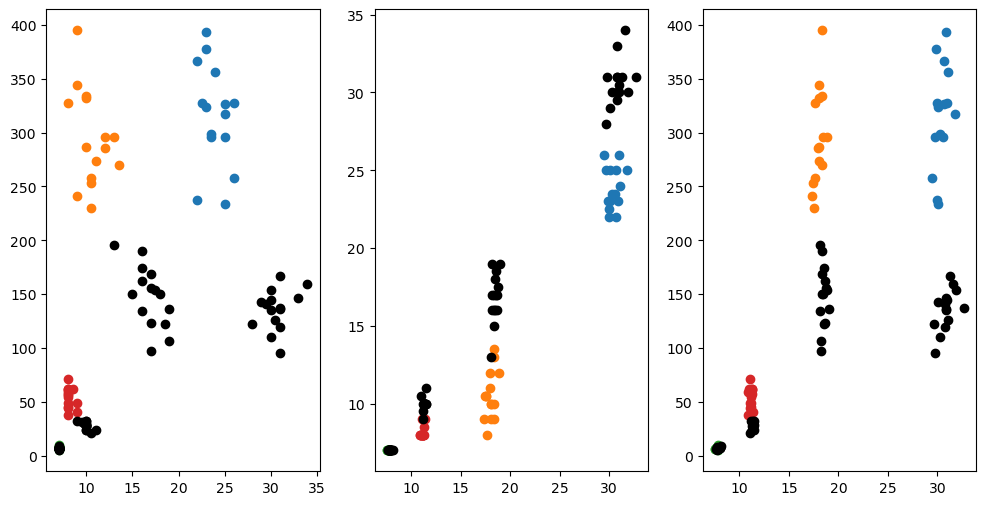

In [50]:
fig,ax = plt.subplot_mosaic('ABC',figsize=(12,6))

ax['A'].scatter(median_isis[:60:4], var_isis[:60:4])
ax['A'].scatter(median_isis[1:60:4], var_isis[1:60:4])
ax['A'].scatter(median_isis[2:60:4], var_isis[2:60:4])
ax['A'].scatter(median_isis[3:60:4], var_isis[3:60:4])

ax['A'].scatter(median_isis[60:120:4], var_isis[60:129:4], color='black')
ax['A'].scatter(median_isis[60+1:120:4], var_isis[60+1:120:4], color='black')
ax['A'].scatter(median_isis[60+2:120:4], var_isis[60+2:120:4], color='black')
ax['A'].scatter(median_isis[60+3:120:4], var_isis[60+3:120:4], color='black')

ax['B'].scatter(mean_isis[:60:4], median_isis[:60:4])
ax['B'].scatter(mean_isis[1:60:4], median_isis[1:60:4])
ax['B'].scatter(mean_isis[2:60:4], median_isis[2:60:4])
ax['B'].scatter(mean_isis[3:60:4], median_isis[3:60:4])

ax['B'].scatter(mean_isis[60:120:4], median_isis[60:129:4], color='black')
ax['B'].scatter(mean_isis[60+1:120:4], median_isis[60+1:120:4], color='black')
ax['B'].scatter(mean_isis[60+2:120:4], median_isis[60+2:120:4], color='black')
ax['B'].scatter(mean_isis[60+3:120:4], median_isis[60+3:120:4], color='black')

ax['C'].scatter(mean_isis[:60:4], var_isis[:60:4])
ax['C'].scatter(mean_isis[1:60:4], var_isis[1:60:4])
ax['C'].scatter(mean_isis[2:60:4], var_isis[2:60:4])
ax['C'].scatter(mean_isis[3:60:4], var_isis[3:60:4])

ax['C'].scatter(mean_isis[60:120:4], var_isis[60:129:4], color='black')
ax['C'].scatter(mean_isis[60+1:120:4], var_isis[60+1:120:4], color='black')
ax['C'].scatter(mean_isis[60+2:120:4], var_isis[60+2:120:4], color='black')
ax['C'].scatter(mean_isis[60+3:120:4], var_isis[60+3:120:4], color='black')



plt.plot()

Damn... it does a pretty good job to behonest :(
maybe I can add some lateral effects somehow and give the network more variance somehow

In [51]:
firing_rates = []
median_isis = []
mean_isis = []
isis = []
for n in range(N_nrn):
    firing_rates.append(len(all_spikes[idc==n]))
    median_isis.append(np.median(np.diff(all_spikes[idc==n])))
    mean_isis.append(np.mean(np.diff(all_spikes[idc==n])))
    isis.append(np.diff(all_spikes[idc==n]))
plt.figure()
# plt.hist(isis[0:16:4],alpha=0.3)
print('test')

test


<Figure size 640x480 with 0 Axes>

### Let's cheat and see if there are information differences hidden in the isi's >:)

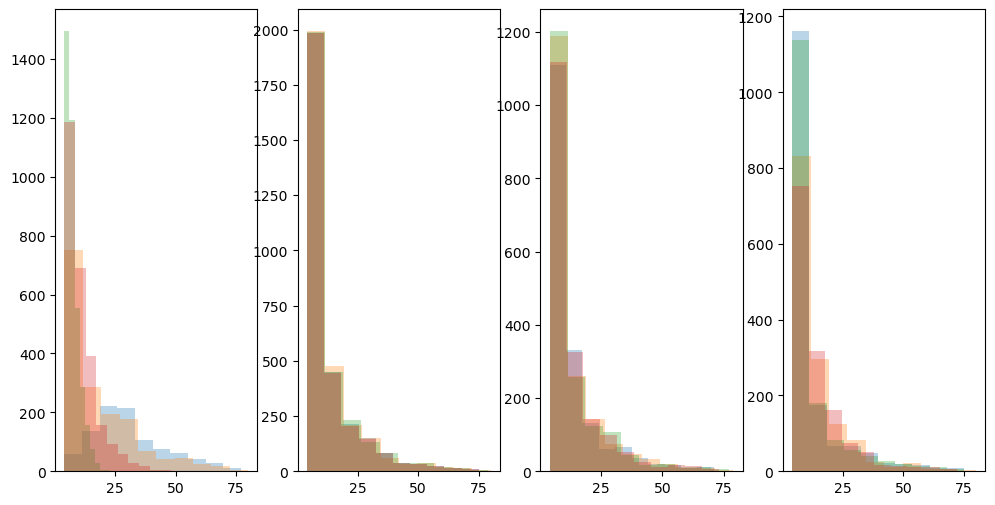

In [52]:
ground_truths = [np.concatenate(isis[n::4]).ravel() for n in range(4)]
shuffled1 = [np.concatenate(isis[n::3]).ravel() for n in range(4)]
shuffled2 = [np.concatenate(isis[n::5]).ravel() for n in range(4)]
shuffled3 = [np.concatenate(isis[n::6]).ravel() for n in range(4)]
fix,ax = plt.subplot_mosaic('ABCD',figsize=(12,6))
    
ax['A'].hist(ground_truths[0],alpha=0.3)
ax['A'].hist(ground_truths[1],alpha=0.3)
ax['A'].hist(ground_truths[2],alpha=0.3)
ax['A'].hist(ground_truths[3],alpha=0.3)

ax['B'].hist(shuffled1[0],alpha=0.3)
ax['B'].hist(shuffled1[1],alpha=0.3)
ax['B'].hist(shuffled1[2],alpha=0.3)
ax['B'].hist(shuffled1[3],alpha=0.3)

ax['C'].hist(shuffled2[0],alpha=0.3)
ax['C'].hist(shuffled2[1],alpha=0.3)
ax['C'].hist(shuffled2[2],alpha=0.3)
ax['C'].hist(shuffled2[3],alpha=0.3)

ax['D'].hist(shuffled3[0],alpha=0.3)
ax['D'].hist(shuffled3[1],alpha=0.3)
ax['D'].hist(shuffled3[2],alpha=0.3)
ax['D'].hist(shuffled3[3],alpha=0.3)

plt.show()

Okay seems like there is some variance in the isi histograms
Can we differentiate all 8 groups??

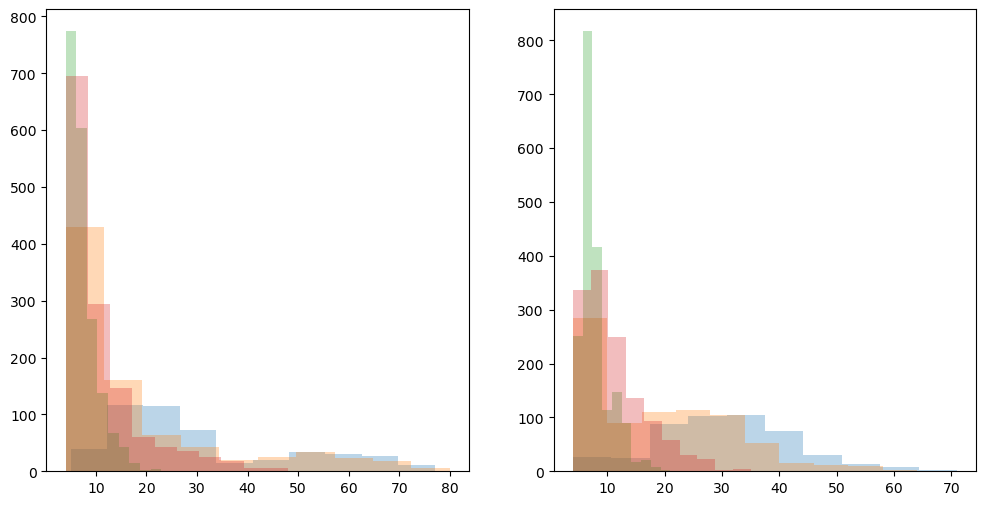

In [53]:
ground_truths_first = [np.concatenate(isis[n:60:4]).ravel() for n in range(4)]
ground_truths_second = [np.concatenate(isis[60+n:120:4]).ravel() for n in range(4)]
fix,ax = plt.subplot_mosaic('AB',figsize=(12,6))
    
ax['A'].hist(ground_truths_first[0],alpha=0.3)
ax['A'].hist(ground_truths_first[1],alpha=0.3)
ax['A'].hist(ground_truths_first[2],alpha=0.3)
ax['A'].hist(ground_truths_first[3],alpha=0.3)

ax['B'].hist(ground_truths_second[0],alpha=0.3)
ax['B'].hist(ground_truths_second[1],alpha=0.3)
ax['B'].hist(ground_truths_second[2],alpha=0.3)
ax['B'].hist(ground_truths_second[3],alpha=0.3)

plt.show()

Wow! They are super good at distinguishing the second group but not the first group...

### Okay back to collecting features...

In [54]:
ccs = np.corrcoef(events_binary.T) # np.mean(np.corrcoef(events_binary.T),axis=0)
mean_ccs = np.mean(ccs,axis=0)

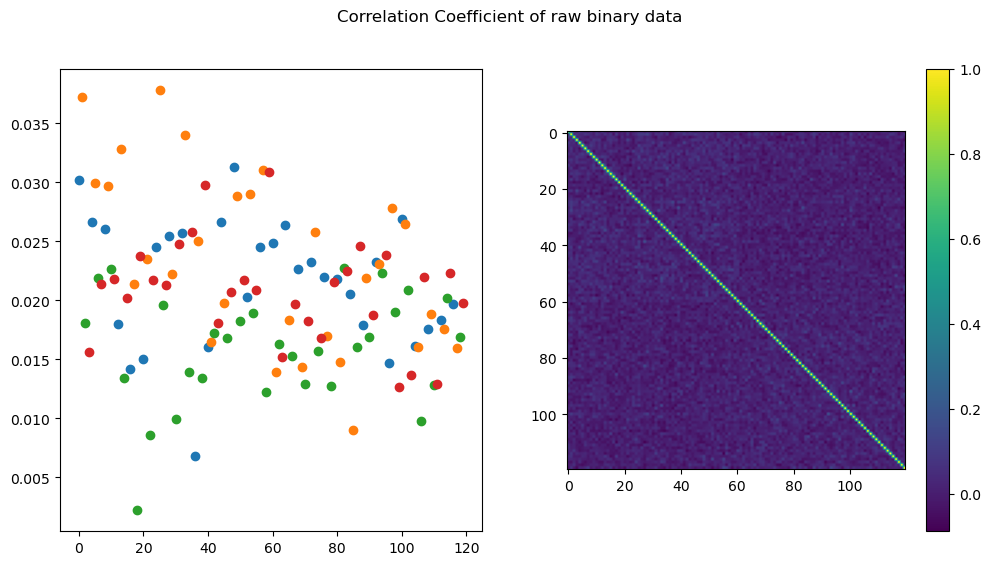

In [55]:
%matplotlib inline

fig, ax = plt.subplot_mosaic('AB', figsize=(12,6))

ax['A'].scatter(np.arange(0,len(np.mean(ccs,axis=0)))[::4],mean_ccs[::4])
ax['A'].scatter(np.arange(0,len(np.mean(ccs,axis=0)))[1::4],mean_ccs[1::4])
ax['A'].scatter(np.arange(0,len(np.mean(ccs,axis=0)))[2::4],mean_ccs[2::4])
ax['A'].scatter(np.arange(0,len(np.mean(ccs,axis=0)))[3::4],mean_ccs[3::4])



im = ax['B'].imshow(ccs)
# ax['B'].colorbar()
fig.suptitle('Correlation Coefficient of raw binary data')
fig.colorbar(im)
plt.show()

spectral power? hmmm let's start by filtering the binary data... 

In [58]:
filt_events.shape, events_binary.shape

((1000, 120), (1000, 120))

In [57]:
filt_events = gaussian_filter1d(events_binary.T,10).T
filt_ccs = np.corrcoef(filt_events.T)
mean_filt_ccs = np.mean(filt_ccs,axis=0)

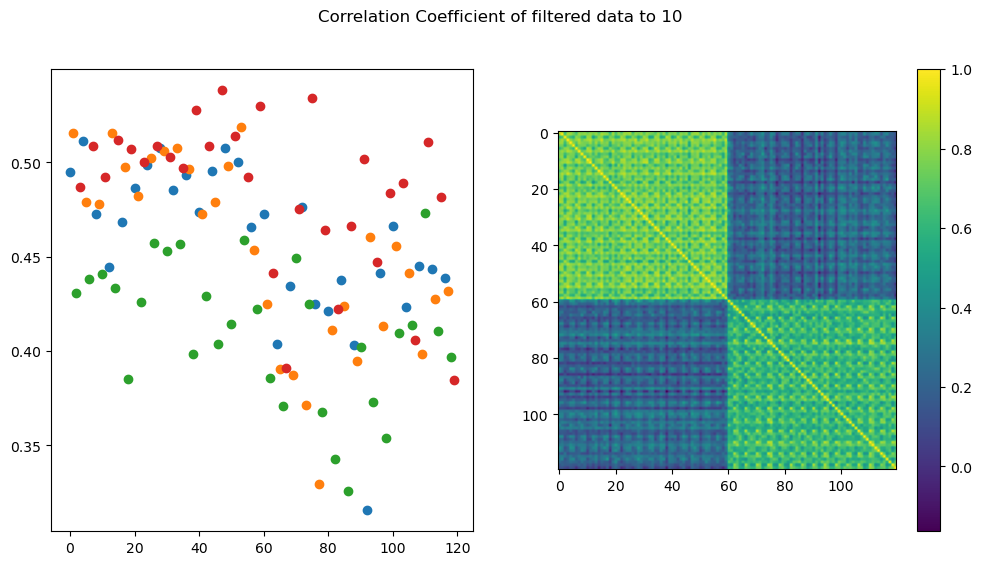

In [59]:
fig, ax = plt.subplot_mosaic('AB', figsize=(12,6))

ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs,axis=0)))[::4],mean_filt_ccs[::4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs,axis=0)))[1::4],mean_filt_ccs[1::4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs,axis=0)))[2::4],mean_filt_ccs[2::4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs,axis=0)))[3::4],mean_filt_ccs[3::4])

im = ax['B'].imshow(filt_ccs)

fig.suptitle('Correlation Coefficient of filtered data to 10')
fig.colorbar(im)
plt.show()


Boy that does not look too good either... maybe if we plot the two responses together??

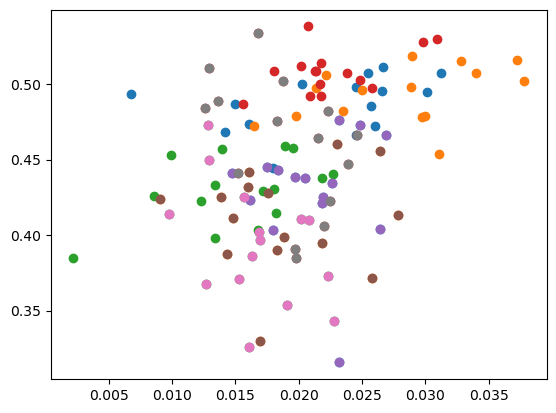

In [60]:
plt.figure()

plt.scatter(mean_ccs[::4],mean_filt_ccs[::4])
plt.scatter(mean_ccs[1::4],mean_filt_ccs[1::4])
plt.scatter(mean_ccs[2::4],mean_filt_ccs[2::4])
plt.scatter(mean_ccs[3::4],mean_filt_ccs[3::4])

plt.scatter(mean_ccs[60:120:4],mean_filt_ccs[60:120:4])
plt.scatter(mean_ccs[60+1:120:4],mean_filt_ccs[60+1:120:4])
plt.scatter(mean_ccs[60+2:120:4],mean_filt_ccs[60+2:120:4])
plt.scatter(mean_ccs[60+3:120:4],mean_filt_ccs[60+3:120:4])

plt.show()

hmmmm it might be a little bit better? maybe we can pass another filter?
the more I look at this the more I start to think it actually looks worse...
actually when I differentiate the colors again, not sure sure anymore ahaha hmmmm ....

In [61]:
filt_events3 = gaussian_filter1d(events_binary.T,3).T
filt_ccs3 = np.corrcoef(filt_events3.T)
mean_filt_ccs3 = np.mean(filt_ccs3,axis=0)

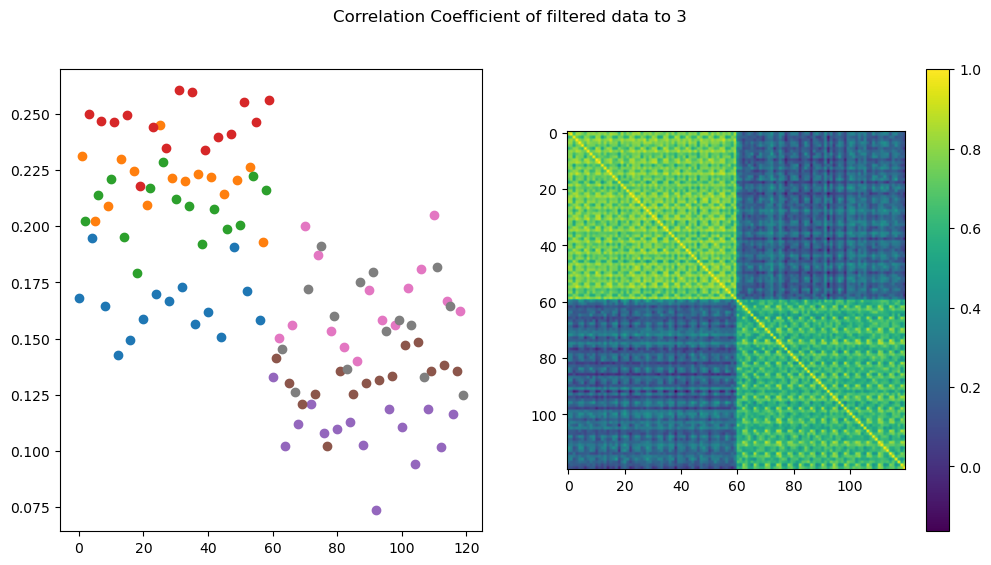

In [62]:
fig, ax = plt.subplot_mosaic('AB', figsize=(12,6))

ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs3,axis=0)))[:60:4],mean_filt_ccs3[:60:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs3,axis=0)))[1:60:4],mean_filt_ccs3[1:60:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs3,axis=0)))[2:60:4],mean_filt_ccs3[2:60:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs3,axis=0)))[3:60:4],mean_filt_ccs3[3:60:4])

ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs3,axis=0)))[60:120:4],mean_filt_ccs3[60:120:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs3,axis=0)))[60+1:120:4],mean_filt_ccs3[60+1:120:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs3,axis=0)))[60+2:120:4],mean_filt_ccs3[60+2:120:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs3,axis=0)))[60+3:120:4],mean_filt_ccs3[60+3:120:4])


im = ax['B'].imshow(filt_ccs)

fig.suptitle('Correlation Coefficient of filtered data to 3')
fig.colorbar(im)
plt.show()


Wow! it looks a lot different! WOWWW actually it discriminates the different inputs pretty well :) can I make it even better???

In [63]:
filt_events1 = gaussian_filter1d(events_binary.T,1).T
filt_ccs1 = np.corrcoef(filt_events1.T)
mean_filt_ccs1 = np.mean(filt_ccs1,axis=0)

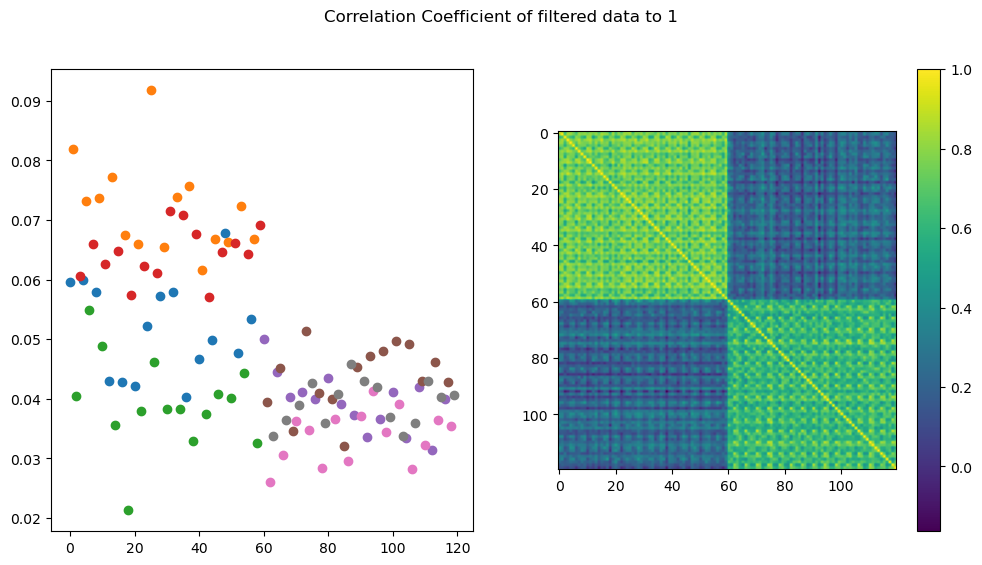

In [64]:
fig, ax = plt.subplot_mosaic('AB', figsize=(12,6))

ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs1,axis=0)))[:60:4],mean_filt_ccs1[:60:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs1,axis=0)))[1:60:4],mean_filt_ccs1[1:60:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs1,axis=0)))[2:60:4],mean_filt_ccs1[2:60:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs1,axis=0)))[3:60:4],mean_filt_ccs1[3:60:4])

ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs1,axis=0)))[60:120:4],mean_filt_ccs1[60:120:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs1,axis=0)))[60+1:120:4],mean_filt_ccs1[60+1:120:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs1,axis=0)))[60+2:120:4],mean_filt_ccs1[60+2:120:4])
ax['A'].scatter(np.arange(0,len(np.mean(filt_ccs1,axis=0)))[60+3:120:4],mean_filt_ccs1[60+3:120:4])


im = ax['B'].imshow(filt_ccs)

fig.suptitle('Correlation Coefficient of filtered data to 1')
fig.colorbar(im)
plt.show()

can we combine this with something to improve it again?

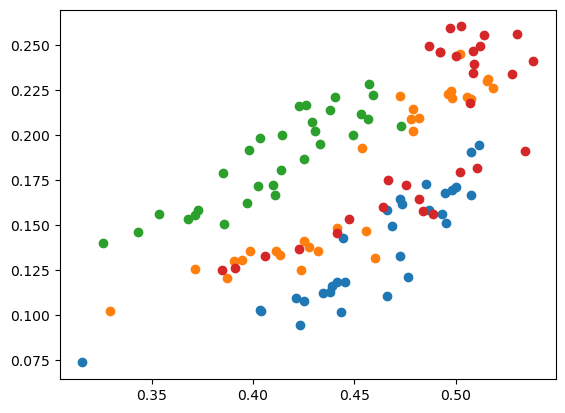

In [65]:
plt.figure()
plt.scatter(mean_filt_ccs[::4],mean_filt_ccs3[::4])
plt.scatter(mean_filt_ccs[1::4],mean_filt_ccs3[1::4])
plt.scatter(mean_filt_ccs[2::4],mean_filt_ccs3[2::4])
plt.scatter(mean_filt_ccs[3::4],mean_filt_ccs3[3::4])
plt.show()

Dang, I thought there would be more differentiation there

# Filtered Spike Distribution Functions as features??

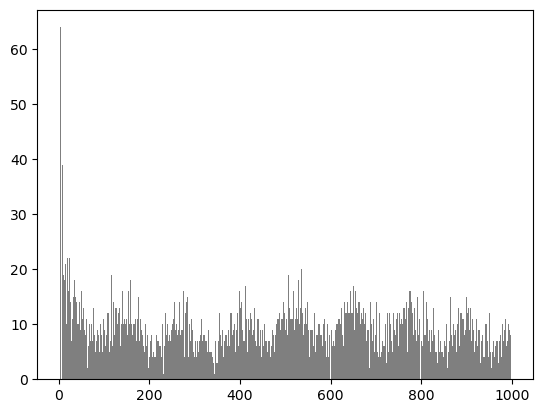

In [66]:
sdf = plt.hist(all_spikes,bins=1000,alpha=0.5,color='black')

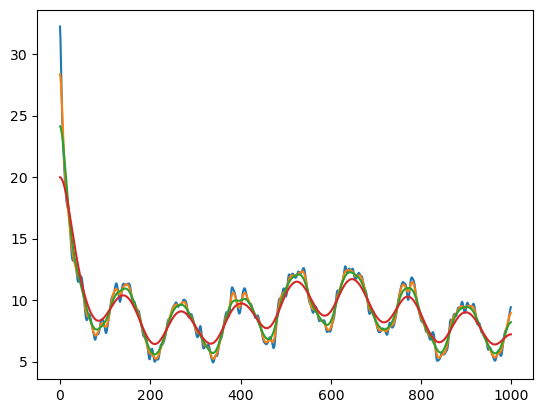

In [67]:
plt.figure()
for i in [3,5,10,20]:
    plt.plot(gaussian_filter1d(sdf[0],i))
    
plt.show()

wait... this only works if I have more than one trial I think... :( shit

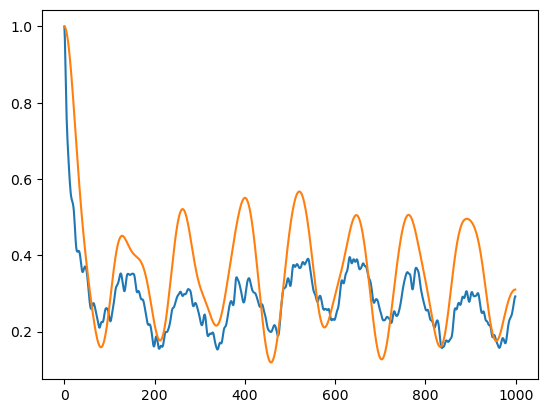

In [68]:

plt.figure()
plt.plot(gaussian_filter1d(sdf[0],3)/np.max(gaussian_filter1d(sdf[0],3)))
plt.plot(gaussian_filter1d(events_binary.T[0],20)/np.max(gaussian_filter1d(events_binary.T[0],20)))
plt.show()


In [69]:
corrs = np.zeros(N_nrn)
for n in range(N_nrn):
    test = np.corrcoef(gaussian_filter1d(sdf[0],3)/np.max(gaussian_filter1d(sdf[0],3)),gaussian_filter1d(events_binary.T[n],3)/np.max(gaussian_filter1d(events_binary.T[n],3)))
    corrs[n] = test[0][1]



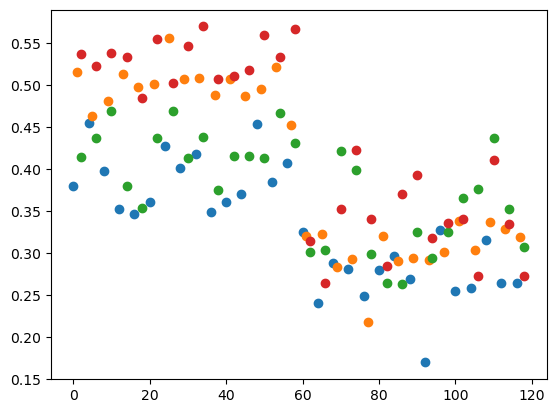

In [70]:
plt.figure()
plt.scatter(np.arange(0,N_nrn)[::4],corrs[::4])
plt.scatter(np.arange(0,N_nrn)[1::4],corrs[1::4])
plt.scatter(np.arange(0,N_nrn)[2::4],corrs[2::4])
plt.scatter(np.arange(0,N_nrn)[2::4],corrs[3::4])

plt.show()

Looks similar to the other cross correlations I did...
wonder what happens if I plot them against each other?

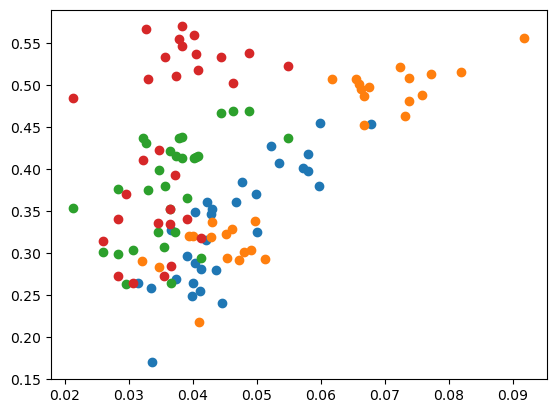

In [71]:
plt.figure()
plt.scatter(mean_filt_ccs1[::4],corrs[::4])
plt.scatter(mean_filt_ccs1[1::4],corrs[1::4])
plt.scatter(mean_filt_ccs1[2::4],corrs[2::4])
plt.scatter(mean_filt_ccs1[2::4],corrs[3::4])
plt.show()

hmmmm... and if I combine all three of them??

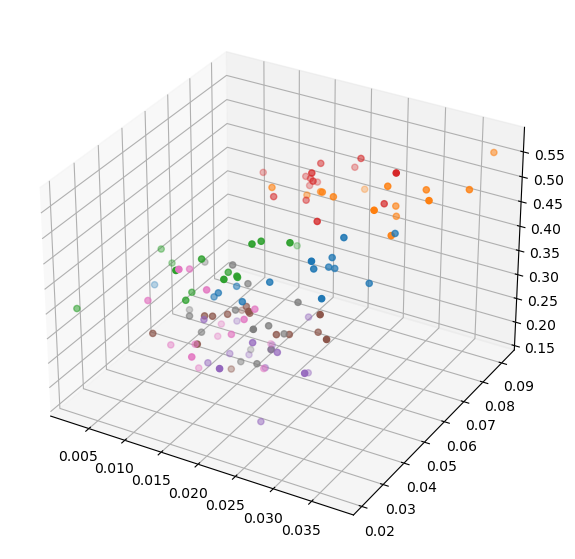

In [72]:
%matplotlib inline
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(mean_ccs[:60:4], mean_filt_ccs1[:60:4],corrs[:60:4])
ax.scatter3D(mean_ccs[1:60:4], mean_filt_ccs1[1:60:4],corrs[1:60:4])
ax.scatter3D(mean_ccs[2:60:4], mean_filt_ccs1[2:60:4],corrs[2:60:4])
ax.scatter3D(mean_ccs[3:60:4], mean_filt_ccs1[3:60:4],corrs[3:60:4])

ax.scatter3D(mean_ccs[60:120:4], mean_filt_ccs1[60:120:4],corrs[60:120:4])
ax.scatter3D(mean_ccs[60+1:120:4], mean_filt_ccs1[60+1:120:4],corrs[60+1:120:4])
ax.scatter3D(mean_ccs[60+2:120:4], mean_filt_ccs1[60+2:120:4],corrs[60+2:120:4])
ax.scatter3D(mean_ccs[60+3:120:4], mean_filt_ccs1[60+3:120:4],corrs[60+3:120:4])

plt.show()

this doesn´t feel bad for ONLY using higher order features :) I'd like to go back and re-do this entire notebook without noise and see the effect

Why don't I consider different filters to be different features? ...

In [73]:
# x = []
x.append(np.mean(filt_ccs,axis=0))
len(x)

AttributeError: 'tuple' object has no attribute 'append'

In [75]:
orders = [1,2,3,5,7,10,15,25,50,100]
mean_filt_ccs = []
filt_corrs = []
for o in orders:
    filt_events = gaussian_filter1d(events_binary.T,o).T
    filt_ccs = np.corrcoef(filt_events.T)
    mean_filt_ccs.append(np.mean(filt_ccs,axis=0))
    
    corrs = np.zeros(N_nrn)
    for n in range(N_nrn):
        test = np.corrcoef(gaussian_filter1d(sdf[0],o)/np.max(gaussian_filter1d(sdf[0],o)),gaussian_filter1d(events_binary.T[n],o)/np.max(gaussian_filter1d(events_binary.T[n],o)))
        corrs[n] = test[0][1]
    filt_corrs.append(corrs)
print(len(filt_corrs))

10


# Let's collect our features now and try to do a PCA !!! :)

In [76]:
features = [firing_rates, median_isis, mean_isis, var_isis, mean_ccs, *mean_filt_ccs, *filt_corrs]
print('Okay so I have %d features... PCA?? '% len(features))

Okay so I have 25 features... PCA?? 


First let's calculate the variance of each feature and see whih features are most useful

In [77]:
plt.figure()
variances = []
means = []
zscores = []
for f in features:
    zscores.append(zscore(f))
    variances.append(np.var(zscores[-1]))
# plt.bar(np.arange(0,len(zscores)), zscores)
plt.show()
# print(zscores)
print(variances)

<Figure size 640x480 with 0 Axes>

[1.0000000000000002, 0.9999999999999998, 0.9999999999999999, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 1.0, 1.0000000000000002, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 1.0, 1.0, 1.0000000000000004, 1.0, 0.9999999999999998, 1.0, 1.0000000000000002, 1.0, 1.0, 0.9999999999999999, 1.0]


In [78]:
np.corrcoef(zscores)

array([[ 1.        , -0.83523757, -0.92742627, -0.78987337, -0.38307783,
        -0.31477936,  0.13538296,  0.41382255,  0.38458043,  0.16266532,
        -0.2675206 , -0.64596612, -0.75794931, -0.66091893, -0.57116695,
        -0.32004305, -0.05173184,  0.17975786,  0.11000373, -0.13461484,
        -0.46806741, -0.72721219, -0.74628479, -0.45942333, -0.36575586],
       [-0.83523757,  1.        ,  0.94905024,  0.49855399,  0.11835282,
        -0.11419193, -0.49633362, -0.66614676, -0.61564551, -0.4243659 ,
        -0.01911911,  0.38924438,  0.54554698,  0.48253324,  0.42362427,
        -0.11785023, -0.33398215, -0.48427009, -0.39140529, -0.15941708,
         0.17430211,  0.45893886,  0.60597748,  0.42988558,  0.36892967],
       [-0.92742627,  0.94905024,  1.        ,  0.7286972 ,  0.26794635,
         0.1183227 , -0.2928174 , -0.51054207, -0.46069797, -0.25174128,
         0.14381565,  0.49685977,  0.59522153,  0.48882559,  0.41705049,
         0.12031395, -0.11882892, -0.29761796, -0

In [80]:
pca = PCA(n_components=2)
pca_features1 = pca.fit_transform(np.transpose(zscores))
pca_df = pd.DataFrame(data=pca_features1, columns=['PC1', 'PC2'])

In [81]:
kmeans = KMeans(
init="random",
n_clusters=8,
n_init=10,
max_iter=300,
random_state=42
)

kmeans.fit(pca_features1)
kmeans.cluster_centers_

C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([[ 4.24240796, -1.64491478],
       [ 4.19721424,  4.03395773],
       [ 0.8051559 , -0.81045271],
       [ 2.1002302 , -3.62297249],
       [-4.21044446,  1.19957664],
       [ 0.35215764,  4.14228028],
       [-1.66506584, -2.15141329],
       [-5.17010247, -0.75622836]])

should I see if we can cluster this??

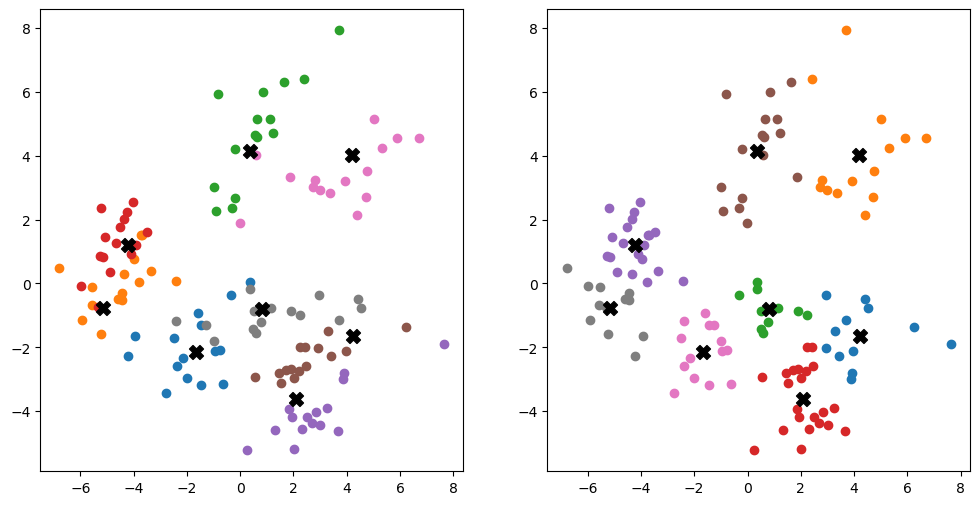

In [82]:
fig,ax = plt.subplot_mosaic('AB',figsize=(12,6))

# ax['A'].scatter(pca_features1.T[0][:60:4],pca_features1.T[1][:60:4])
# ax['A'].scatter(pca_features1.T[0][1:60:4],pca_features1.T[1][1:60:4])
# ax['A'].scatter(pca_features1.T[0][2:60:4],pca_features1.T[1][2:60:4])
# ax['A'].scatter(pca_features1.T[0][3:60:4],pca_features1.T[1][3:60:4])

# ax['A'].scatter(pca_features1.T[0][60:120:4],pca_features1.T[1][60:120:4])
# ax['A'].scatter(pca_features1.T[0][60+1:120:4],pca_features1.T[1][60+1:120:4])
# ax['A'].scatter(pca_features1.T[0][60+2:120:4],pca_features1.T[1][60+2:120:4])
# ax['A'].scatter(pca_features1.T[0][60+3:120:4],pca_features1.T[1][60+3:120:4])

[ax['A'].scatter(pca_features1.T[0][labels==i],pca_features1.T[1][labels==i]) for i in range(8)]


ax['A'].scatter(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1],marker='X',color='black',s=100)

[ax['B'].scatter(pca_features1.T[0][kmeans.labels_==i],pca_features1.T[1][kmeans.labels_==i]) for i in range(8)]
ax['B'].scatter(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1],marker='X',color='black',s=100)

# ax['A'].scatter(pca_features.T[0][:60:4],pca_features.T[1][:60:4])
# ax['A'].scatter(pca_features.T[0][1:60:4],pca_features.T[1][1:60:4])
# ax['A'].scatter(pca_features.T[0][2:60:4],pca_features.T[1][2:60:4])
# ax['A'].scatter(pca_features.T[0][3:60:4],pca_features.T[1][3:60:4])

# ax['A'].scatter(pca_features.T[0][60:120:4],pca_features.T[1][60:120:4])
# ax['A'].scatter(pca_features.T[0][60+1:120:4],pca_features.T[1][60+1:120:4])
# ax['A'].scatter(pca_features.T[0][60+2:120:4],pca_features.T[1][60+2:120:4])
# ax['A'].scatter(pca_features.T[0][60+3:120:4],pca_features.T[1][60+3:120:4])

plt.show()

interesting...

what if we use 3 principle components?

In [83]:
pca = PCA(n_components=3)
pca_features3 = pca.fit_transform(np.transpose(zscores))
pca_df = pd.DataFrame(data=pca_features3, columns=['PC1', 'PC2', 'PC3'])

In [84]:
kmeans = KMeans(
init="random",
n_clusters=8,
n_init=10,
max_iter=300,
random_state=42
)

kmeans.fit(pca_features3)
kmeans.cluster_centers_

C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([[-4.68143984,  1.23817662, -1.17354732],
       [ 4.19458699,  3.49814196, -0.34335557],
       [-1.43181059, -2.01190915,  2.09074992],
       [ 2.8725416 , -4.05997424,  0.82646435],
       [-0.22983535,  0.14388503, -2.14095227],
       [ 1.02472089,  5.41918828,  0.8995388 ],
       [-4.47226595, -0.2150504 ,  1.09716903],
       [ 2.76985456, -1.92299311, -0.80870901]])

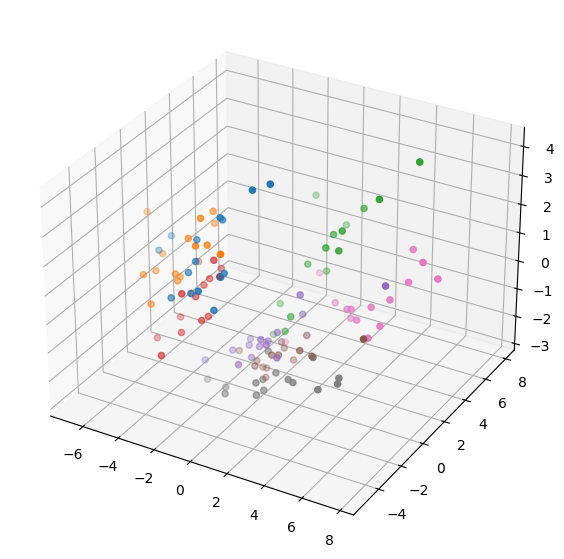

In [85]:
%matplotlib inline
fig = plt.figure(figsize = (10, 7))
ax1 = plt.axes(projection ="3d")

[ax1.scatter3D(pca_features3.T[0][labels==i],pca_features3.T[1][labels==i],pca_features3.T[2][labels==i]) for i in range(8)]
plt.show()



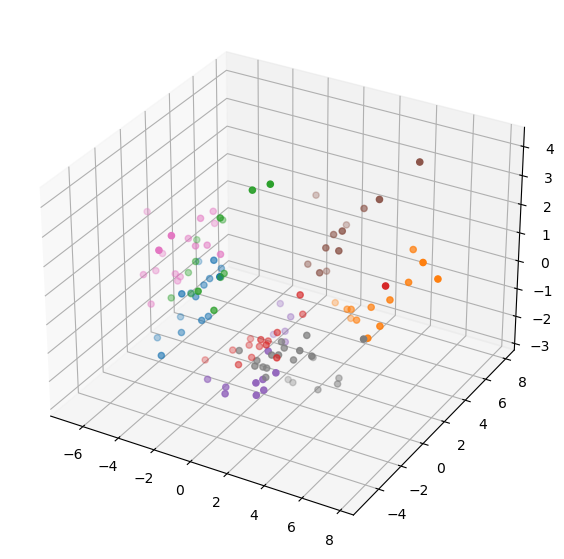

In [86]:

fig = plt.figure(figsize = (10, 7))
ax2 = plt.axes(projection = "3d")
[ax2.scatter3D(pca_features3.T[0][kmeans.labels_==i],pca_features3.T[1][kmeans.labels_==i],pca_features3.T[2][kmeans.labels_==i]) for i in range(8)]

plt.show()

# t-sne !!
Maybe I'll start out with the raw data?
pre-define a window/kernel size, (binary image/mask of the raster). This will be my high dimensional representation of each neuron spike... The thing is, I know a priori that each neuron is independent right? So t-sne should in the end also realize this and disregard the vertical dimension of the image...


In [194]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import seaborn as sns


In [190]:
window_dim = (31, N_nrn) # time by neuron num

In [191]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.transpose(zscores))

[t-SNE] Computing 119 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.002s...
[t-SNE] Computed neighbors for 120 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 3.212940
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.953735
[t-SNE] KL divergence after 300 iterations: 0.148154


In [209]:
kmeans = KMeans(
init="random",
n_clusters=8,
n_init=10,
max_iter=300,
random_state=42
)

kmeans.fit(tsne_results)
kmeans.cluster_centers_

C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([[ 4.8171177 , -4.780863  ],
       [ 1.0724113 ,  6.4396467 ],
       [ 5.0247808 , -2.4139245 ],
       [-0.76664126, -2.2181191 ],
       [-2.2364142 , -5.1163335 ],
       [-0.6914056 ,  2.9657938 ],
       [-4.5164986 , -3.9729488 ],
       [-0.45733792,  8.077036  ]], dtype=float32)

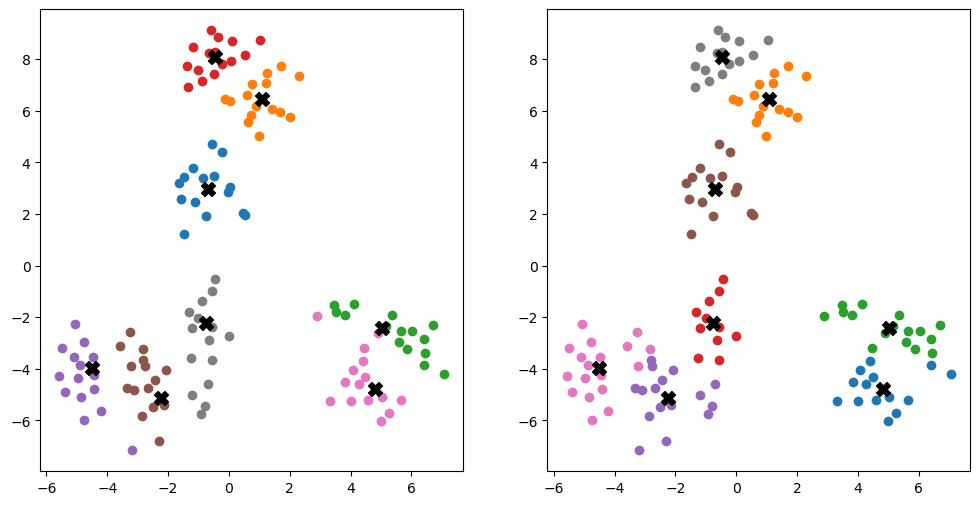

In [212]:
fig,ax = plt.subplot_mosaic('AB',figsize=(12,6))
[ax['A'].scatter(tsne_results[:,0][labels==i], tsne_results[:,1][labels==i]) for i in range(8)]
ax['A'].scatter(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1],marker='X',color='black',s=100)

[ax['B'].scatter(tsne_results[:,0][kmeans.labels_==i],tsne_results[:,1][kmeans.labels_==i]) for i in range(8)]
ax['B'].scatter(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1],marker='X',color='black',s=100)

plt.show()

This looks much better than the PCA!